In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval

In [38]:
names = {}
names[20] = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "stagei",
    "skills",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    "wait",
    "patience",
    "test",
]
names[21] = [
    "seed",
    "depth",
    "window",
    "method",
    "stagei",
    "skills",
    "budget",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    "wait",
    "patience",
    "test",
]


def get_df(v):

    if v > 21:
        n = names[21]
    else:
        n = names[v]
    df = pd.read_csv(f"/storage1/fs1/chien-ju.ho/Active/tree/output{v}.txt", names=n)
    # df['dup'] = (df.epoch == 0).astype(int)
    # df['dup'] = df.groupby(categories)['dup'].cumsum()
    # df = df.groupby(categories + ['dup']).filter(lambda x: x['wait'].max() == x['patience'].iloc[0])
    # df = df[df.wait == 0]
    # df = df.drop_duplicates(categories + ['dup'], keep='last')
    # df = df.groupby(categories).mean().reset_index()
    df = df[~df.stagei.isna()]
    df["stagei"] = df.stagei.astype(int)
    df["skillsi"] = df.apply(
        lambda x: "_".join(x.skills.split("_")[: x.stagei + 1]), axis=1
    )
    if v >= 21:
        df[["budget_type", "budget"]] = df.budget.str.split("_", expand=True)
        df["budget"] = np.log2(df.budget.astype(int))
    if v == 20:
        df["budget"] = np.log2(df.budget)
    return df

In [65]:
%%time
df = get_df(27)
df = df[(df.method.isin(['crit123-0-1-10-0.2','crit123-10-11-0-0.2']))]
df['method'] = df.method.str.replace('crit123','crit')
df['opt'] = df.opt+"-"+df.lr.astype(str)
df.shape

CPU times: user 343 ms, sys: 5.11 ms, total: 348 ms
Wall time: 415 ms


(23335, 20)

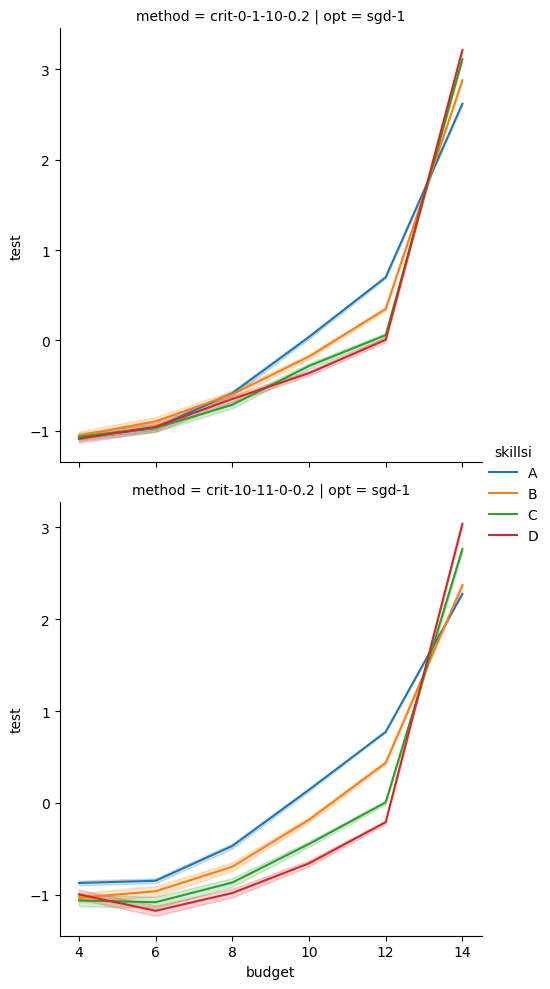

In [66]:
g = sns.relplot(
    data=df[df.skillsi.isin(["A", "B", "C", "D"])],
    x="budget",
    y="test",
    hue="skillsi",
    row="method",
    col="opt",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)

In [7]:
df[df.skillsi.isin(["A", "B", "C", "D"])].pivot_table(
    index="skillsi", columns="budget", values="seed", aggfunc="count"
)

budget,4.0,6.0,8.0,10.0,12.0,14.0,16.0
skillsi,,,,,,,
A,239,369,205,170,152,188,170
B,48,57,34,30,30,30,30
C,46,57,34,30,30,30,30
D,45,56,34,30,30,30,30


In [10]:
df[(df.skillsi == "D") & (df.method == "critical-1-5") & (df.budget == 10)]

,seed,depth,window,method,stagei,skills,budget,opt,lr,num_nodes,num_layers,epoch,loss,acc,score,wait,patience,test,skillsi,budget_type
14397,100,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.077965,0.511765,0,0,20,-0.446001,D,equal
14495,101,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.135434,0.501846,0,0,20,-0.624039,D,equal
14596,102,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.170315,0.509674,0,0,20,-0.481851,D,equal
14693,103,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,0.911090,0.522919,0,0,20,-0.608742,D,equal
14771,104,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.054000,0.527267,0,0,20,-0.315014,D,equal
14852,105,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.222169,0.477844,0,0,20,-1.251669,D,equal
14945,106,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,0.930904,0.491623,0,0,20,-0.479740,D,equal
15014,107,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.501308,0.520004,0,0,20,-0.255050,D,equal
15087,108,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,0.984025,0.506912,0,0,20,-0.108069,D,equal
15192,109,4,0,critical-1-5,0,D,10.0,sgd-1,1,16,1,0,1.133623,0.520615,0,0,20,-0.563251,D,equal


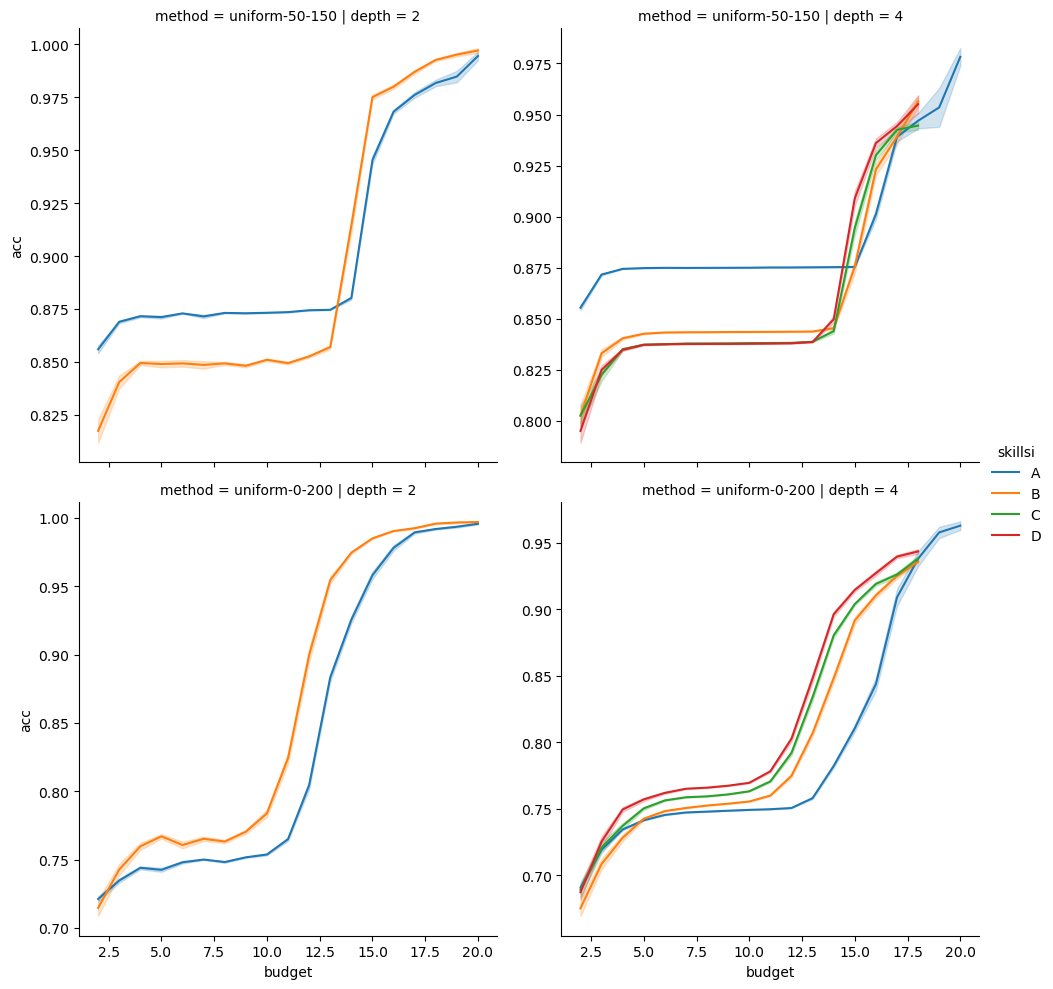

In [24]:
g = sns.relplot(
    data=df23[df23.skillsi.isin(["A", "B", "C", "D"])],
    x="budget",
    y="acc",
    hue="skillsi",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)

In [62]:
def get_cats(df):
    df_cats = []
    for decisions in [2, 3, 4]:

        mixed = "ABCD"[:decisions]
        high = mixed[-1]
        low = mixed[0]
        onepass = "_".join(mixed)
        up, updown, down = [], [], []

        for i in range(1, decisions):
            up.append(mixed[:i])
            updown.append(mixed[:i])

        up.append(mixed)
        updown.append(mixed)
        down.append(mixed)

        for i in range(1, decisions):
            down.append(mixed[i:])
            updown.append(mixed[i:])

        up, updown, down = "_".join(up), "_".join(updown), "_".join(down)
        skill_categories = {
            "up": up,
            "updown": updown,
            "down": down,
            "mixed": mixed,
            "onepass": onepass,
            "low": low,
            "high": high,
            "lowf": low,
            "highf": high,
            "low_adj": low,
            "high_adj": high,
            "A": "A",
            "B": "B",
            "C": "C",
            "D": "D",
        }

        for label, cat in skill_categories.items():
            df_ = df[df.depth == decisions]
            if not df_.size:
                continue
            df_ = df_[df_.skillsi.apply(lambda x: cat.startswith(x))]
            df_["skills"] = cat
            df_["label"] = label
            df_["depth"] = decisions
            if label in ["low", "high"]:
                df_["budget"] = np.log2((2**df_.budget) / decisions)
            if label in ["low_adj", "high_adj"]:
                df_["budget"] = np.log2((2**df_.budget) * decisions)
            df_cats.append(df_)
    df_cats = pd.concat(df_cats)
    # df_cats['method'] = df_cats.method.apply(lambda x: '-'.join(x.split('-')[:2]))
    return df_cats


df_cats = get_cats(df)

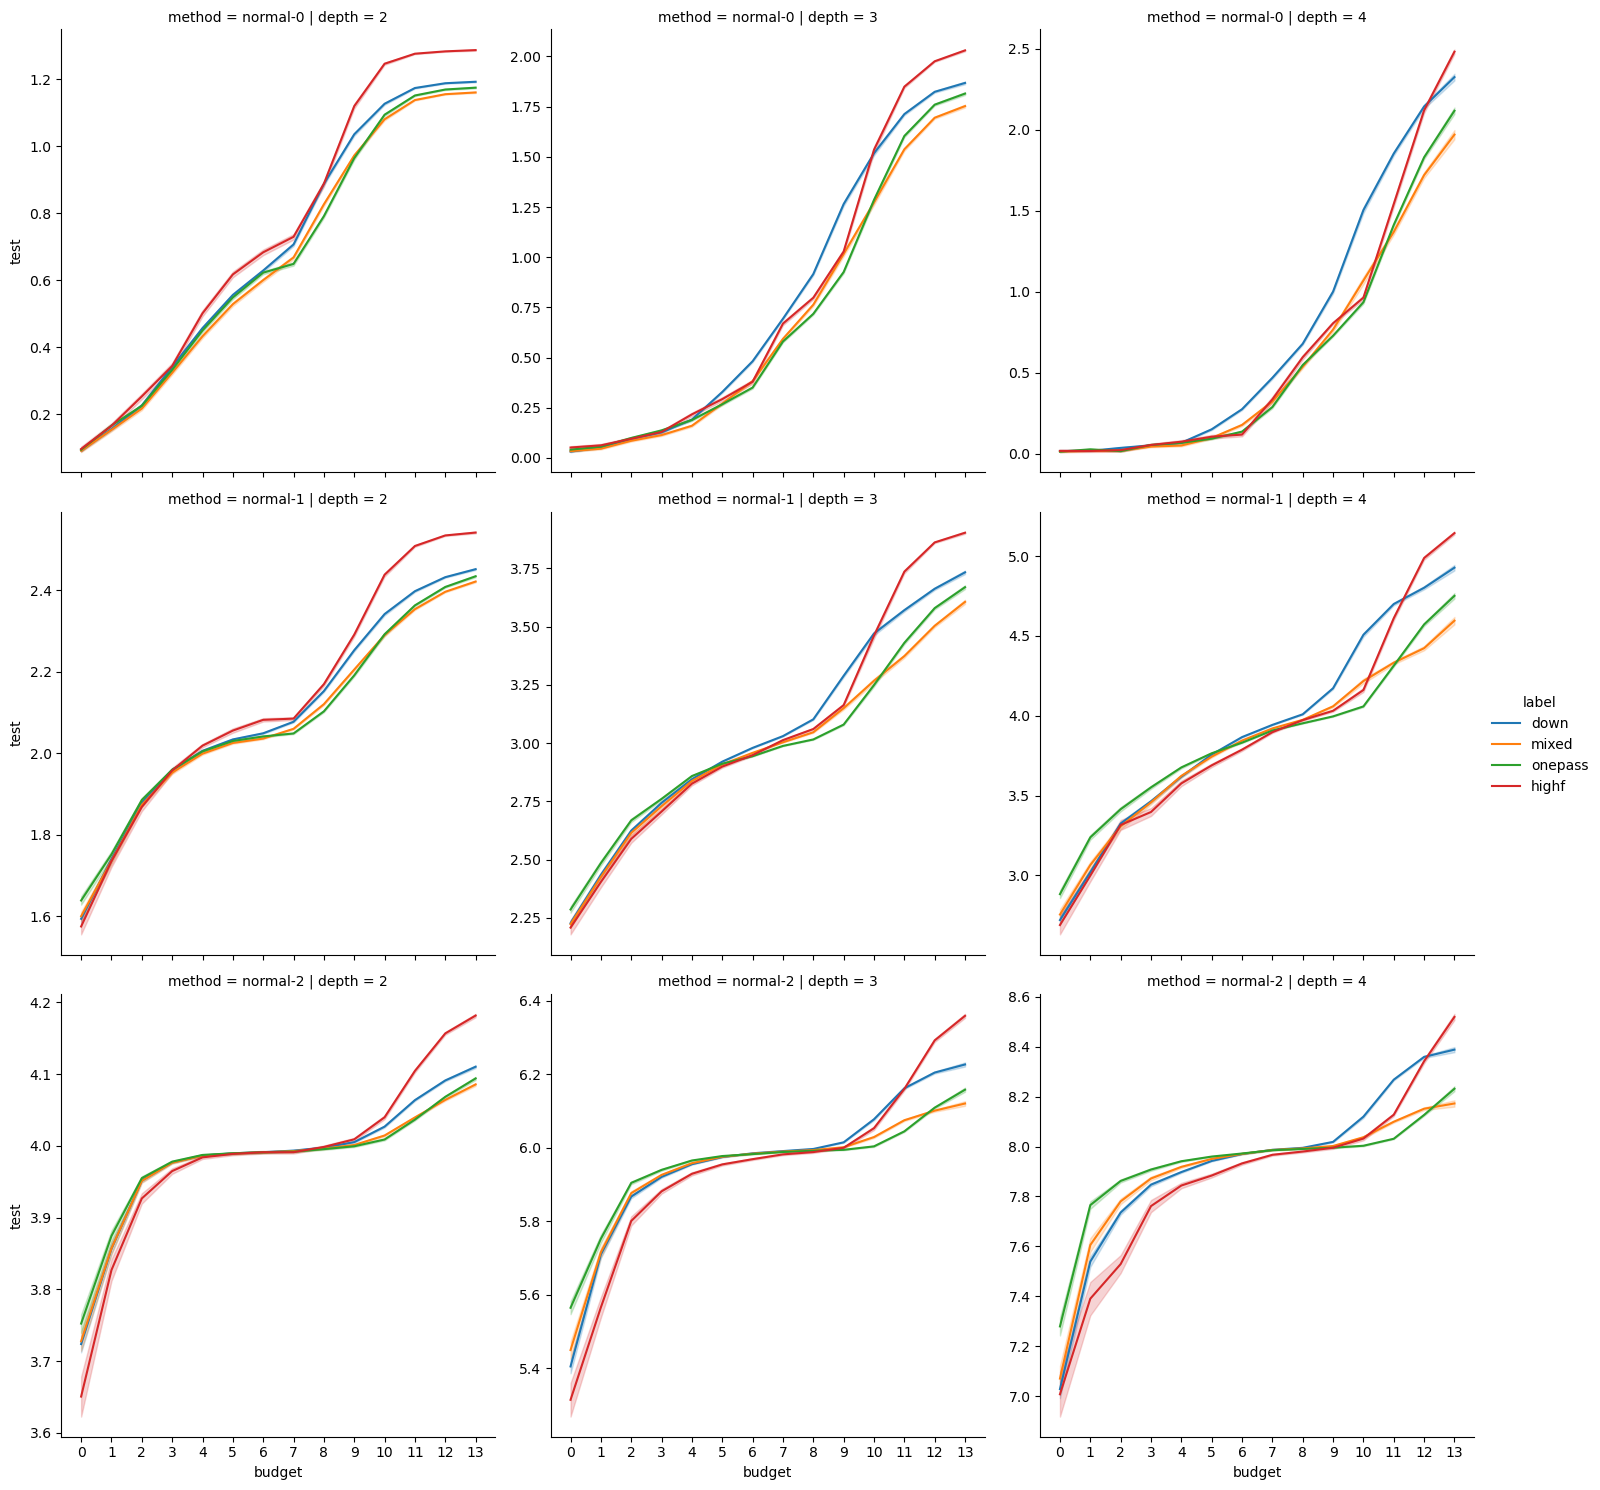

In [111]:
df_ = df_cats20.sort_values(["budget", "method"])

df_ = df_[
    df_.label.isin(
        [
            # "updown",
            # "up",
            "down",
            "mixed",
            "onepass",
            # "lowf",
            "highf",
            # "low",
            # "high",
            # "A","B","C","D",
        ]
    )
]

g = sns.relplot(
    data=df_,
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
plt.xticks(np.arange(df_.budget.min(), df_.budget.max() + 1, 1))
display(g.figure)
plt.close(g.figure)

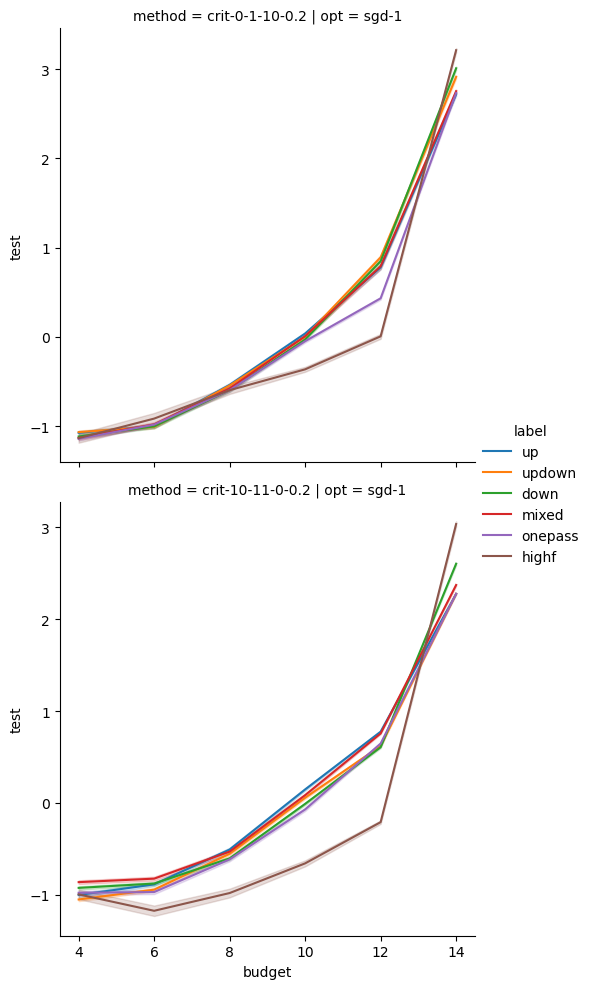

In [64]:
df_ = df_cats.sort_values(["budget", "method"])
# df_ = df_[df_.method == 'normal-2']

df_ = df_[
    df_.label.isin(
        [
            "updown",
            "up",
            "down",
            "mixed",
            "onepass",
            # "lowf",
            "highf",
            # "low",
            # "high",
            # "low",
            # "A","B","C","D",
        ]
    )
]

g = sns.relplot(
    data=df_,
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="opt",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
# plt.xticks(np.arange(df_.budget.min(),df_.budget.max()+1,1))
display(g.figure)
plt.close(g.figure)

In [16]:
df_algo = pd.read_csv(
    "algo3.txt",
    sep=";",
    names=[
        "seed",
        "decisions",
        "mode",
        "start",
        "end",
        "trial",
        "inc",
        "best_branch",
        "branch_vals",
        "budget",
        "wp_chosen",
        "wp_equal",
        "wp_high",
    ],
)
df_algo[["A", "B", "C", "D"]] = (
    df_algo.budget.str.slice(1, -1).str.split(expand=True).astype(int)
)
df_algo["budget2"] = np.log2(df_algo[["A", "B", "C", "D"]].sum(axis=1))
df_algo["branch_vals"] = df_algo.branch_vals.apply(
    lambda x: {k: round(v, 4) for k, v in literal_eval(x).items()}
)
# df_algo = df_algo.melt(id_vars=['seed','decisions','mode','start','end','trial','inc','budget','budget2'], value_vars=['wp_chosen','wp_equal','wp_high'])
df_algo

,seed,decisions,mode,start,end,trial,inc,best_branch,branch_vals,budget,wp_chosen,wp_equal,wp_high,A,B,C,D,budget2
0,136,4,critical-1-2,16,1000000,0.0625,1.5,2,"{0: 2.2789, 1: 2.6115, 2: 2.7357, 3: 2.7094}",[ 4 4 20 4],2.392676,2.543230,2.431779,4,4,20,4,5.000000
1,4,4,critical-1-2,16,1000000,0.0625,1.5,3,"{0: 2.602, 1: 2.6727, 2: 2.5663, 3: 2.7436}",[ 4 4 4 20],2.606359,2.029212,2.640338,4,4,4,20,5.000000
2,2,4,critical-1-2,16,1000000,0.0625,1.5,2,"{0: 2.1183, 1: 2.5813, 2: 2.6414, 3: 2.2156}",[ 4 4 20 4],2.316425,2.534987,2.737295,4,4,20,4,5.000000
3,1,4,critical-1-2,16,1000000,0.0625,1.5,0,"{0: 2.7261, 1: 2.2579, 2: 2.6942, 3: 1.926}",[20 4 4 4],2.506262,2.261158,2.517018,20,4,4,4,5.000000
4,28,4,critical-1-2,16,1000000,0.0625,1.5,3,"{0: 2.5119, 1: 1.8459, 2: 2.4051, 3: 2.6574}",[ 4 4 4 20],2.646016,2.737941,2.247121,4,4,4,20,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,164,4,critical-1-2,16,1000000,0.0625,1.5,1,"{0: 2.7216, 1: 2.7457, 2: 2.7304, 3: 2.7144}",[3492 4404 2244 1220],2.699099,3.100997,3.107774,3492,4404,2244,1220,13.471675
2701,142,4,critical-1-2,16,1000000,0.0625,1.5,2,"{0: 2.6721, 1: 2.6388, 2: 2.7131, 3: 2.672}",[148 36 468 340],2.689883,2.614305,2.740012,148,36,468,340,9.954196
2702,6,4,critical-1-2,16,1000000,0.0625,1.5,2,"{0: 2.7374, 1: 3.1238, 2: 3.1682, 3: 2.7494}",[ 4244 276 15220 5828],3.222004,3.163923,3.237149,4244,276,15220,5828,14.642052
2703,90,4,critical-1-2,16,1000000,0.0625,1.5,3,"{0: 2.7123, 1: 2.6322, 2: 2.6908, 3: 2.7364}",[ 4 2260 852 1924],2.677793,2.707116,2.918936,4,2260,852,1924,12.299208


In [17]:
df_algo[df_algo.seed == 1][["best_branch", "branch_vals", "budget", "budget2"]]

,best_branch,branch_vals,budget,budget2
3,0,"{0: 2.7261, 1: 2.2579, 2: 2.6942, 3: 1.926}",[20 4 4 4],5.000000
151,1,"{0: 2.7286, 1: 2.7444, 2: 2.609, 3: 2.7391}",[20 20 4 4],5.584963
297,0,"{0: 2.7043, 1: 2.642, 2: 2.6571, 3: 2.5121}",[52 20 4 4],6.321928
424,0,"{0: 2.752, 1: 2.7408, 2: 2.7045, 3: 2.7378}",[100 20 4 4],7.000000
565,0,"{0: 2.7336, 1: 2.7136, 2: 2.6935, 3: 2.7223}",[164 20 4 4],7.584963
695,2,"{0: 2.6881, 1: 2.7172, 2: 2.7357, 3: 2.6584}",[164 20 100 4],8.169925
816,1,"{0: 2.704, 1: 2.7513, 2: 2.6952, 3: 2.7423}",[164 164 100 4],8.754888
938,1,"{0: 2.7505, 1: 2.7509, 2: 2.721, 3: 2.703}",[164 388 100 4],9.357552
1066,2,"{0: 2.7098, 1: 2.7195, 2: 2.7453, 3: 2.7043}",[164 388 436 4],9.954196
1199,3,"{0: 2.726, 1: 2.6173, 2: 2.7197, 3: 2.7402}",[164 388 436 500],10.539159


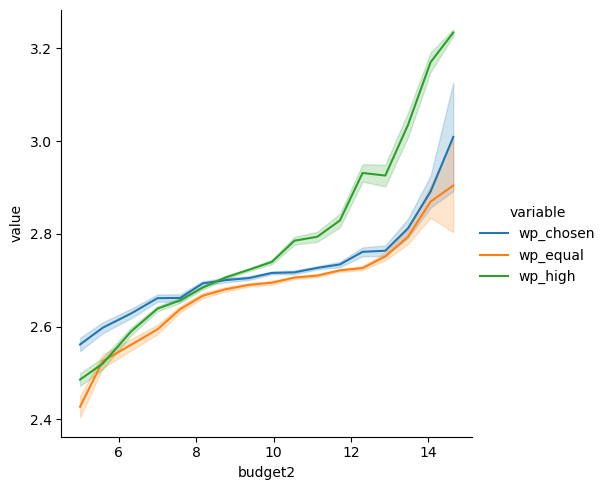

In [6]:
g = sns.relplot(
    data=df_algo.melt(
        id_vars=[
            "seed",
            "decisions",
            "mode",
            "start",
            "end",
            "trial",
            "inc",
            "budget",
            "budget2",
        ],
        value_vars=["wp_chosen", "wp_equal", "wp_high"],
    ),
    x="budget2",
    y="value",
    hue="variable",
    kind="line",
    errorbar="se",
)
display(g.figure)
plt.close(g.figure)

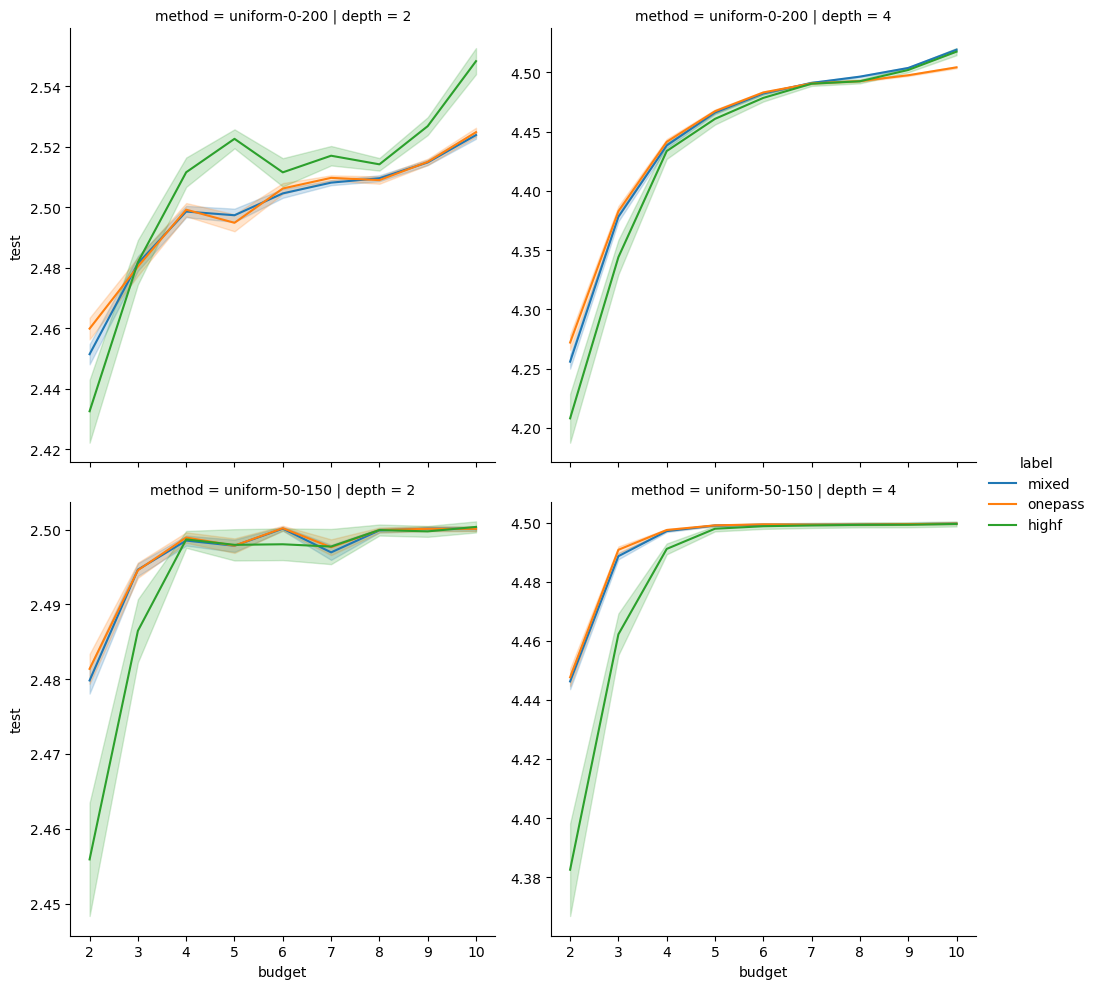

In [28]:
g = sns.relplot(
    data=df_.query("budget <= 10"),
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
# plt.xticks(np.arange(df_.budget.min(),df_.budget.max()+1,1))
display(g.figure)
plt.close(g.figure)

In [189]:
%%time
df19 = get_df(19)

CPU times: user 5.84 s, sys: 46.5 ms, total: 5.89 s
Wall time: 1min 19s


In [190]:
df19

,seed,depth,window,method,budget,stagei,skills,opt,lr,num_nodes,num_layers,patience,epoch,loss,acc,score,wait,test,dup,skillsi
0,100,2,0,normal-0-0,1,0,AB_B,adam,1,16,1,20,62.0,0.771609,0.533500,0.163727,0.0,0.148556,1.0,AB
1,100,2,0,normal-0-0,1,0,A_AB_B,adam,1,16,1,20,38.0,0.764101,0.511500,0.192478,0.0,0.150419,1.0,A
2,100,2,0,normal-0-0,1,0,A_B,adam,1,16,1,20,4.0,0.735110,0.519750,0.001151,0.0,-0.000228,1.0,A
3,100,2,0,normal-0-0,1,1,AB_B,adam,1,16,1,20,0.0,0.771051,0.527000,0.163727,0.0,0.148556,1.0,AB_B
4,100,2,0,normal-0-0,1,1,A_AB_B,adam,1,16,1,20,0.0,0.750809,0.515500,0.192478,0.0,0.150419,1.0,A_AB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21523,423,2,0,normal-2-0,64,1,A_B,adam,1,16,1,20,0.0,0.375102,0.897500,4.003348,0.0,3.966667,1.0,A_B
21524,423,2,0,normal-2-0,64,2,A_AB_B,adam,1,16,1,20,0.0,0.325371,0.900000,4.015070,0.0,3.990765,1.0,A_AB_B
21525,424,2,0,normal-2-0,64,0,A_AB_B,adam,1,16,1,20,50.0,0.256983,0.921500,4.054123,0.0,3.903750,1.0,A
21526,424,2,0,normal-2-0,64,1,A_AB_B,adam,1,16,1,20,0.0,0.307645,0.907625,4.054123,0.0,3.903750,1.0,A_AB


In [191]:
df19_ = pd.concat([df19, df18_])
df19_

,seed,depth,window,method,budget,stagei,skills,opt,lr,num_nodes,...,patience,epoch,loss,acc,score,wait,test,dup,skillsi,vision
0,100,2,0.0,normal-0-0,1,0,AB_B,adam,1.0,16.0,...,20.0,62.0,0.771609,0.53350,0.163727,0.0,0.148556,1.0,AB,NaN
1,100,2,0.0,normal-0-0,1,0,A_AB_B,adam,1.0,16.0,...,20.0,38.0,0.764101,0.51150,0.192478,0.0,0.150419,1.0,A,NaN
2,100,2,0.0,normal-0-0,1,0,A_B,adam,1.0,16.0,...,20.0,4.0,0.735110,0.51975,0.001151,0.0,-0.000228,1.0,A,NaN
3,100,2,0.0,normal-0-0,1,1,AB_B,adam,1.0,16.0,...,20.0,0.0,0.771051,0.52700,0.163727,0.0,0.148556,1.0,AB_B,NaN
4,100,2,0.0,normal-0-0,1,1,A_AB_B,adam,1.0,16.0,...,20.0,0.0,0.750809,0.51550,0.192478,0.0,0.150419,1.0,A_AB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129723,717,4,NaN,normal-0-0,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.121786,NaN,D,4.0
129724,718,4,NaN,normal-0-0,1,1,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.267044,NaN,A,1.0
129725,718,4,NaN,normal-0-0,1,1,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011311,NaN,B,2.0
129726,718,4,NaN,normal-0-0,1,1,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.353656,NaN,C,3.0


In [192]:
df_cats = []
for decisions in [2, 3, 4]:

    mixed = "ABCD"[:decisions]
    high = mixed[-1]
    onepass = "_".join(mixed)
    up, updown, down = [], [], []

    for i in range(1, decisions):
        up.append(mixed[:i])
        updown.append(mixed[:i])

    up.append(mixed)
    updown.append(mixed)
    down.append(mixed)

    for i in range(1, decisions):
        down.append(mixed[i:])
        updown.append(mixed[i:])

    up, updown, down = "_".join(up), "_".join(updown), "_".join(down)
    skill_categories = {
        "up": up,
        "updown": updown,
        "down": down,
        "mixed": mixed,
        "onepass": onepass,
    }

    for label, cat in skill_categories.items():
        df_ = df19[df19.depth == decisions]
        df_ = df_[df_.skillsi.apply(lambda x: cat.startswith(x))]
        df_ = (
            df_.groupby(["seed", "depth", "method", "budget"]).test.max().reset_index()
        )
        df_["skills"] = cat
        df_["label"] = label
        df_["depth"] = decisions
        df_cats.append(df_)

    df_ = df18_[df18_.depth == decisions]
    df_ = df_[df_.skillsi.apply(lambda x: high.startswith(x))]
    df_ = df_.groupby(["seed", "depth", "method", "budget"]).test.max().reset_index()
    df_["skills"] = high
    df_["budget"] *= 4
    df_["label"] = "high"
    df_["depth"] = decisions
    df_cats.append(df_)


df_cats = pd.concat(df_cats)
df_cats

,seed,depth,method,budget,test,skills,label
0,100,2,normal-0-0,1,0.150419,A_AB,up
1,100,2,normal-0-0,2,0.174783,A_AB,up
2,100,2,normal-0-0,4,0.309078,A_AB,up
3,100,2,normal-0-0,8,0.384087,A_AB,up
4,100,2,normal-0-0,16,0.394021,A_AB,up
...,...,...,...,...,...,...,...
15325,714,4,normal-0-0,4,-0.235666,D,high
15326,715,4,normal-0-0,4,0.049980,D,high
15327,716,4,normal-0-0,4,0.015926,D,high
15328,717,4,normal-0-0,4,0.121786,D,high


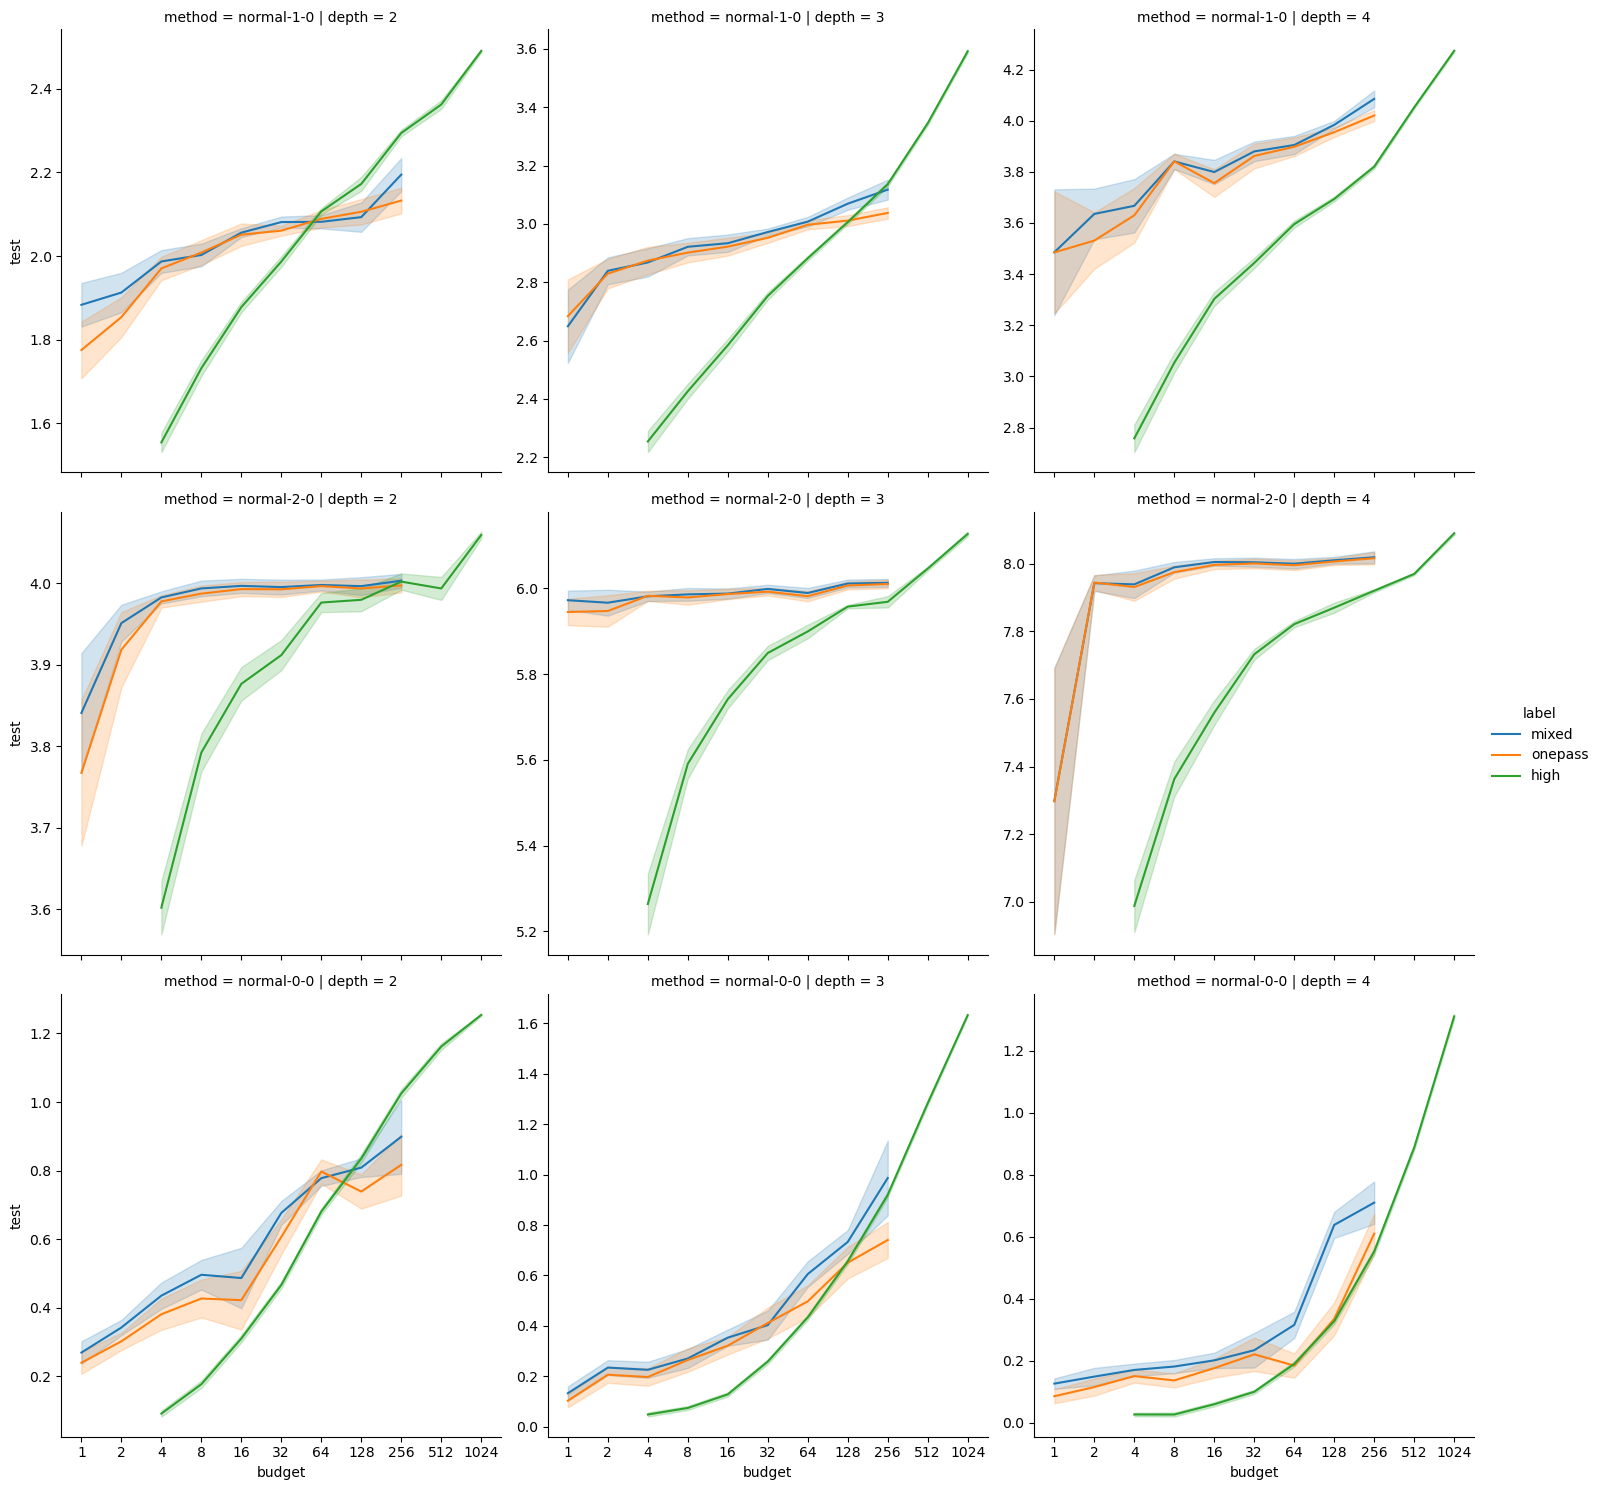

In [193]:
df_ = df_cats.sort_values("budget").astype({"budget": "str"})

g = sns.relplot(
    data=df_[df_.label.isin(["mixed", "onepass", "high"])],
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
display(g.figure)
plt.close(g.figure)

methods = list(df_.method.unique())


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"

        max_val = max(value_ for idx_, value_ in row.items() if idx_[0] == idx[0])
        if value == max_val:
            style += "font-weight: bold;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", "label"], values="test"
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=3))


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", "label"], values="seed", aggfunc=len
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=0))

In [ ]:
df_[(df_.method == "normal-2-0") & (df_.depth == 4)].pi

In [124]:
names = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "vision",
    "temp",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    "wait",
    "patience",
    "test",
]

categories = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "vision",
    "temp",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "patience",
]


def get_df(v):
    df = pd.read_csv(
        f"/storage1/fs1/chien-ju.ho/Active/tree/output{v}.txt", names=names
    )
    df["dup"] = (df.epoch == 0).astype(int)
    df["dup"] = df.groupby(categories)["dup"].cumsum()
    df = df.groupby(categories + ["dup"]).filter(
        lambda x: x["wait"].max() == x["patience"].iloc[0]
    )
    df = df[df.wait == 0]
    df = df.drop_duplicates(categories + ["dup"], keep="last")
    df = df.groupby(categories).mean().reset_index()
    # df['skill'] = df.apply(lambda x: f"({x.vision}, {x.temp})", axis=1)
    return df

In [125]:
%%time
df18 = get_df(18)

CPU times: user 2min 9s, sys: 13.1 s, total: 2min 22s
Wall time: 2min 22s


In [126]:
df18

,seed,depth,window,method,budget,vision,temp,opt,lr,num_nodes,num_layers,patience,epoch,loss,acc,score,wait,test,dup
0,0,2,0,normal-0-0,1,1,0.00,adam,1.0,16,1,20,112.0,0.635044,0.630500,0.613997,0.0,0.581451,1.0
1,0,2,0,normal-0-0,1,2,0.00,adam,1.0,16,1,20,2.0,0.803121,0.444500,-0.124295,0.0,-0.126232,1.0
2,0,2,0,normal-0-0,1,2,0.01,adam,1.0,16,1,20,45.0,0.775687,0.544250,0.244185,0.0,0.264131,1.0
3,0,2,0,normal-0-0,1,2,0.10,adam,1.0,16,1,20,0.0,0.835660,0.450250,-0.068380,0.0,-0.114524,1.0
4,0,2,0,normal-0-0,1,2,1.00,adam,1.0,16,1,20,34.0,0.758305,0.533000,0.249632,0.0,0.171739,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306980,717,4,0,normal-0-0,1,4,1.00,adam,1.0,16,1,20,0.0,0.961463,0.491625,-0.151735,0.0,0.045267,1.0
306981,718,4,0,normal-0-0,1,1,0.00,adam,1.0,16,1,20,35.0,0.760386,0.502125,-0.187205,0.0,-0.267044,1.0
306982,718,4,0,normal-0-0,1,2,0.00,adam,1.0,16,1,20,59.0,0.841145,0.504875,-0.066216,0.0,0.011311,1.0
306983,718,4,0,normal-0-0,1,3,0.00,adam,1.0,16,1,20,3.0,0.885183,0.476625,-0.292095,0.0,-0.353656,1.0


In [151]:
df18_ = (
    df18[df18.temp == 0]
    .groupby(["seed", "depth", "method", "vision", "budget"])
    .test.max()
    .reset_index()
)
df18_["skills"] = df18_.vision.replace({1: "A", 2: "B", 3: "C", 4: "D"})
df18_["skillsi"] = df18_.skills
df18_["stagei"] = 1
df18_

,seed,depth,method,vision,budget,test,skills,skillsi,stagei
0,0,2,normal-0-0,1,1,0.581451,A,A,1
1,0,2,normal-0-0,1,2,0.527010,A,A,1
2,0,2,normal-0-0,1,4,0.286910,A,A,1
3,0,2,normal-0-0,1,8,0.748186,A,A,1
4,0,2,normal-0-0,1,16,0.708196,A,A,1
...,...,...,...,...,...,...,...,...,...
129723,717,4,normal-0-0,4,1,0.121786,D,D,1
129724,718,4,normal-0-0,1,1,-0.267044,A,A,1
129725,718,4,normal-0-0,2,1,0.011311,B,B,1
129726,718,4,normal-0-0,3,1,-0.353656,C,C,1


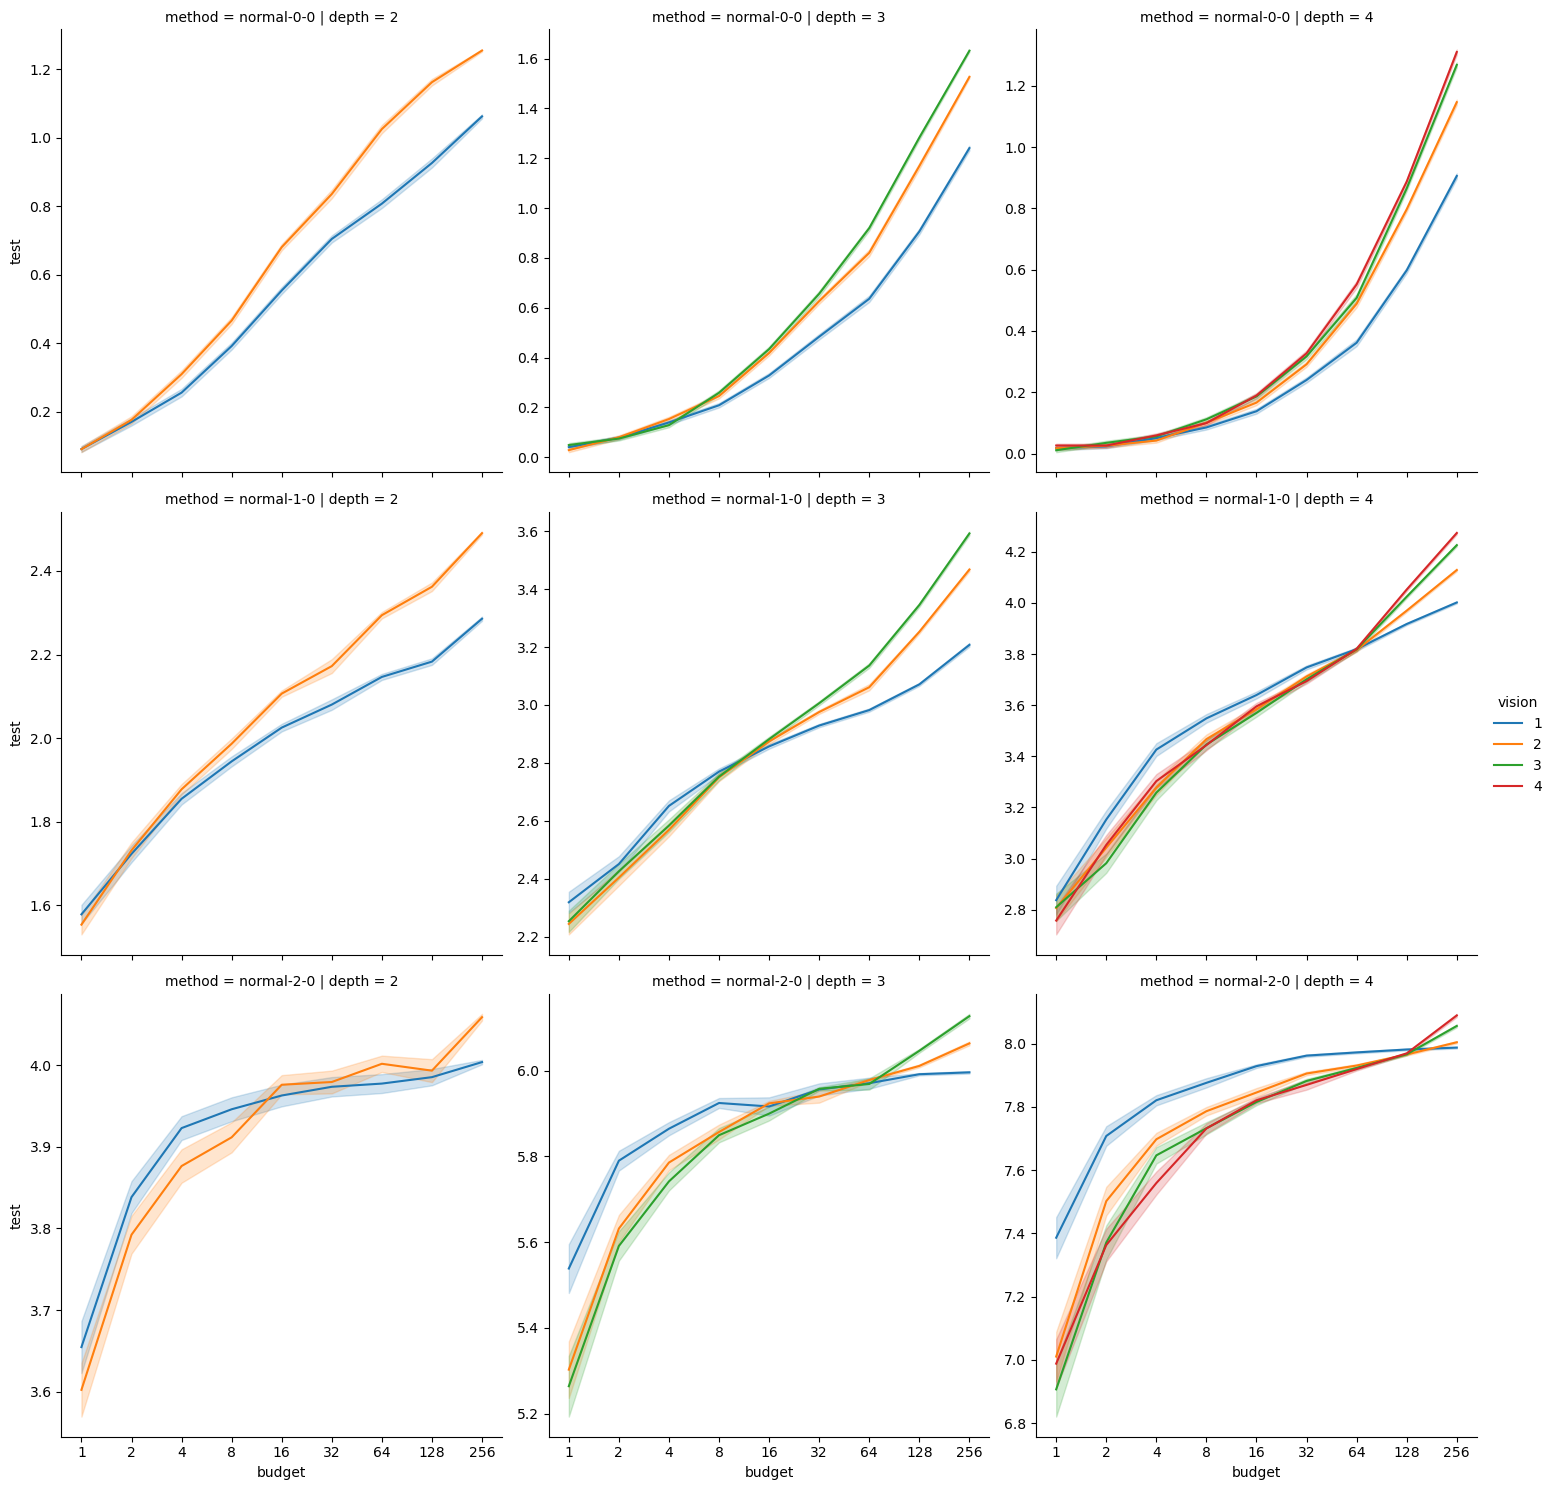

In [104]:
# skill = 'temp'
skill = "vision"

if skill == "temp":
    df_ = df18[df18.temp != 0]
else:
    df_ = df18[df18.temp == 0]
df_ = df_.astype({"budget": "str", "vision": "str", "temp": "str"})

g = sns.relplot(
    data=df_,
    x="budget",
    y="test",
    hue=skill,
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
display(g.figure)
plt.close(g.figure)

methods = list(df_.method.unique())


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"

        max_val = max(value_ for idx_, value_ in row.items() if idx_[0] == idx[0])
        if value == max_val:
            style += "font-weight: bold;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", skill], values="test"
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=3))


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", skill], values="seed", aggfunc=len
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=0))